<a href="https://colab.research.google.com/github/abdulazizElmohandis/Soil-Mind/blob/AI-dev-v0/irrigation_modeipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# ============================================
# 1.IMPORTS & CONFIGURATION
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')

CONFIG = {
    'random_state': 42,
    'test_size': 0.2,
    'val_size': 0.1,
    'epochs': 100,
    'batch_size': 32,
    'model_name': 'irrigation_model_v2'
}

print("✅ Imports Complete")
print(f"TensorFlow Version: {tf.__version__}")


✅ Imports Complete
TensorFlow Version: 2.19.0


📊 DATASET FEATURE RANGES
       soil_moisture   temperature      humidity
count   23995.000000  23995.000000  23995.000000
mean       45.433090     24.263780     58.521052
std        26.007715      6.756751     30.073448
min         1.000000     11.220000      0.590000
25%        23.000000     18.580000     33.980000
50%        45.000000     22.150000     61.310000
75%        68.000000     29.590000     86.360000
max        90.000000     45.560000     96.000000


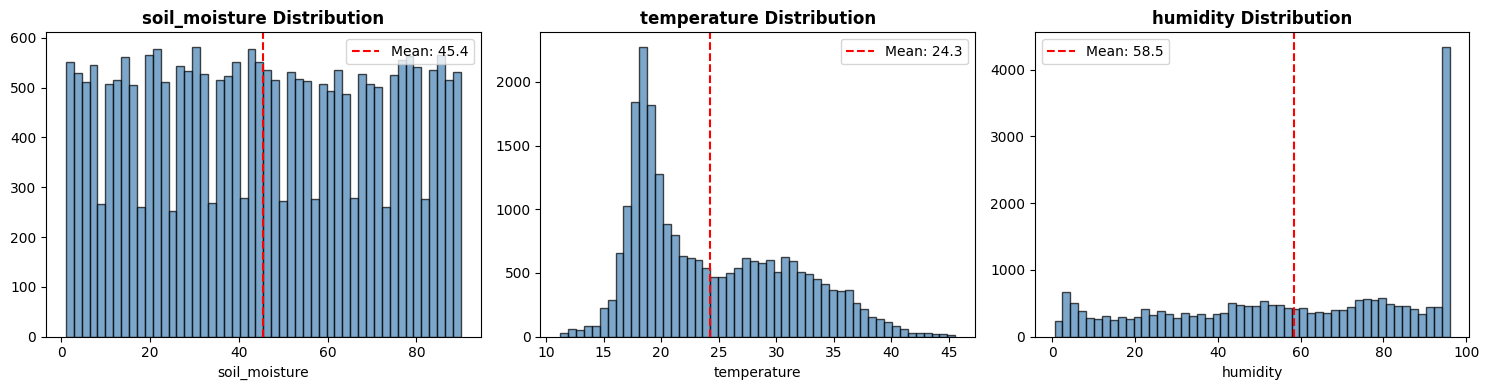

✅ Saved: feature_distributions.png


In [28]:
# ============================================
# 2.LOAD DATA & ANALYZE RANGES
# ============================================
df = pd.read_csv('irrigation_dataset.csv')

print("📊 DATASET FEATURE RANGES")
print("=" * 60)
print(df[['soil_moisture', 'temperature', 'humidity']].describe())

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, col in enumerate(['soil_moisture', 'temperature', 'humidity']):
    axes[idx].hist(df[col], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.1f}')
    axes[idx].set_title(f'{col} Distribution', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].legend()
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150)
plt.show()
print("✅ Saved: feature_distributions.png")

In [30]:
# ============================================
# 3.: DEFINE AGRONOMIC RULES
# ============================================
print("\n🌱 AGRONOMIC IRRIGATION RULES")
print("=" * 60)

"""
IRRIGATION DECISION LOGIC (Based on agronomic principles):

Rule 1 - CRITICAL (Must Irrigate):
   • Soil moisture < 25% → Always irrigate (plant stress zone)

Rule 2 - HIGH PRIORITY:
   • Soil moisture < 40% AND temperature > 28°C → Irrigate
   • (Hot weather + moderate low moisture = high evapotranspiration)

Rule 3 - MODERATE PRIORITY:
   • Soil moisture < 35% AND humidity < 45% → Irrigate
   • (Dry air + low moisture = increased water loss)

Rule 4 - STRESS CONDITIONS:
   • Soil moisture < 50% AND temperature > 35°C → Irrigate
   • (Extreme heat requires more soil water buffer)

Rule 5 - COMBINED STRESS:
   • Soil moisture < 45% AND temperature > 30°C AND humidity < 40% → Irrigate
   • (Triple stress condition)

Rule 6 - NO IRRIGATION NEEDED:
   • Soil moisture >= 70% → Never irrigate (risk of overwatering)
   • Soil moisture >= 55% AND temperature < 25°C → No irrigation
"""

def create_irrigation_labels(row):
    sm = row['soil_moisture']
    temp = row['temperature']
    hum = row['humidity']

    # Rule 6: No irrigation - soil is wet enough
    if sm >= 70:
        return 0

    # Rule 1: Critical - very dry soil
    if sm < 25:
        return 1

    # Rule 2: Hot + moderately dry
    if sm < 40 and temp > 28:
        return 1

    # Rule 3: Dry air + low moisture
    if sm < 35 and hum < 45:
        return 1

    # Rule 4: Extreme heat buffer
    if sm < 50 and temp > 35:
        return 1

    # Rule 5: Triple stress
    if sm < 45 and temp > 30 and hum < 40:
        return 1

    # Rule 6: Comfortable conditions - no irrigation
    if sm >= 55 and temp < 25:
        return 0

    # Moderate zone: base decision on soil moisture threshold
    if sm < 40:
        return 1
    else:
        return 0

# Apply rules
df['irrigation_new'] = df.apply(create_irrigation_labels, axis=1)

print("✅ Rule-Based Labels Created")
print(f"\n📊 New Label Distribution:")
print(f"   OFF (0): {(df['irrigation_new']==0).sum():,} ({(df['irrigation_new']==0).mean()*100:.1f}%)")
print(f"   ON  (1): {(df['irrigation_new']==1).sum():,} ({(df['irrigation_new']==1).mean()*100:.1f}%)")

# Compare old vs new labels
print(f"\n🔄 Label Comparison (Old vs New):")
comparison = pd.crosstab(df['irrigation'], df['irrigation_new'],
                          rownames=['Old'], colnames=['New'])
print(comparison)
agreement = (df['irrigation'] == df['irrigation_new']).mean()
print(f"\n   Agreement with original labels: {agreement*100:.1f}%")


🌱 AGRONOMIC IRRIGATION RULES
✅ Rule-Based Labels Created

📊 New Label Distribution:
   OFF (0): 13,215 (55.1%)
   ON  (1): 10,780 (44.9%)

🔄 Label Comparison (Old vs New):
New     0     1
Old            
0    7598  3424
1    5617  7356

   Agreement with original labels: 62.3%



📊 VISUALIZING NEW LABELS


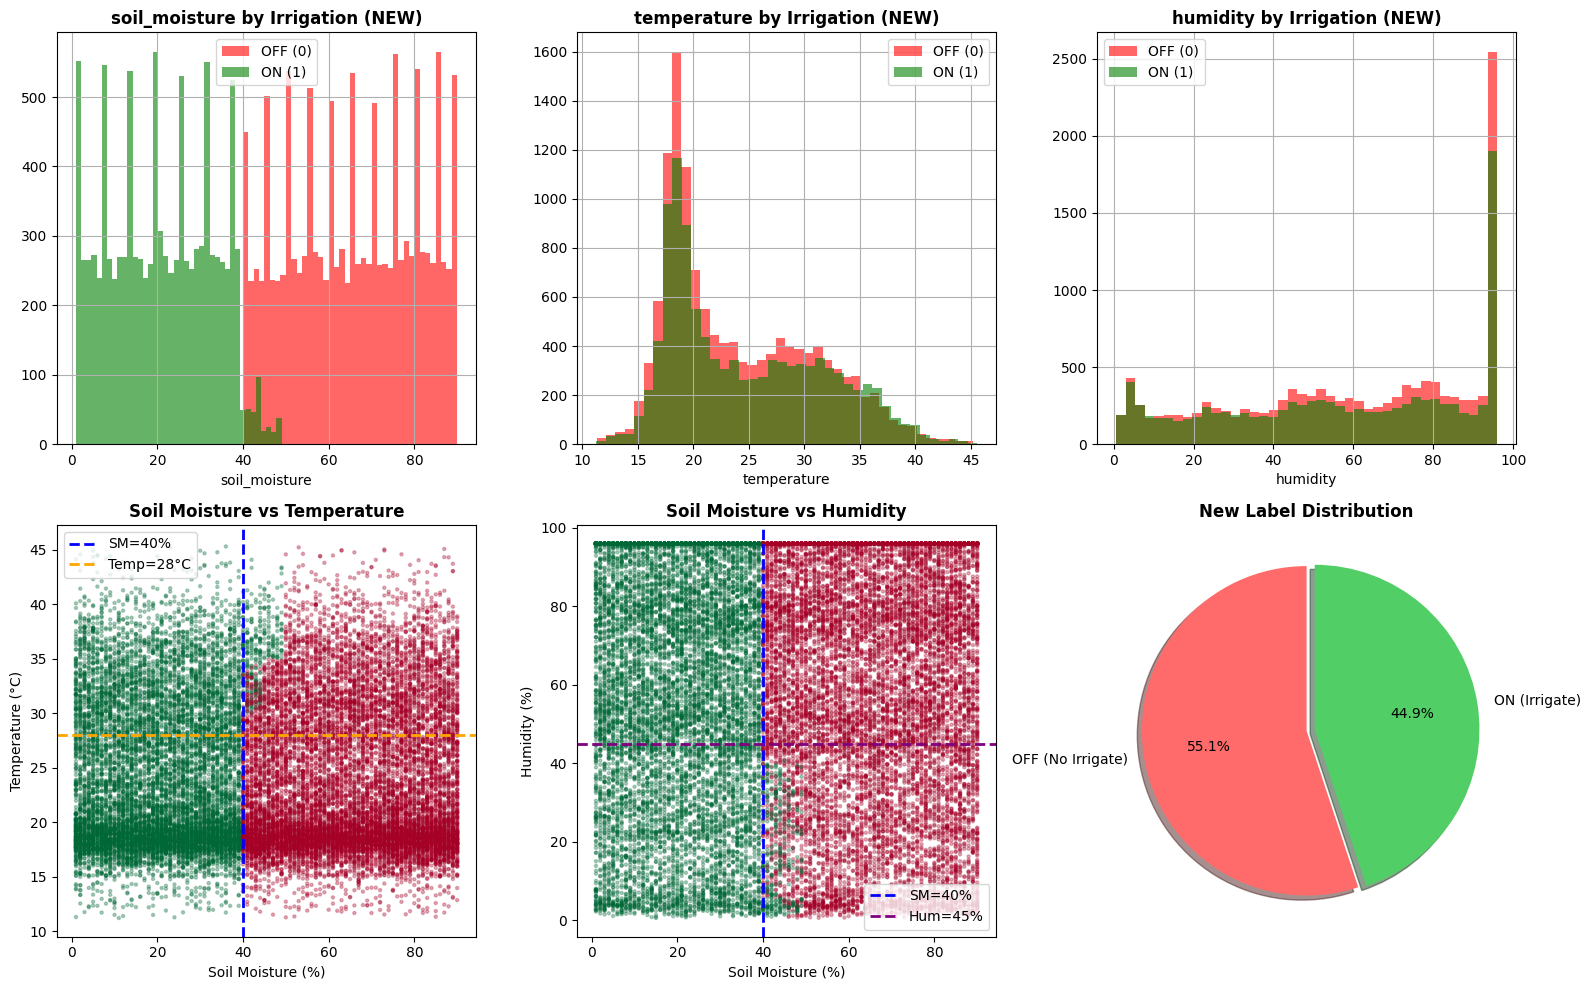

✅ Saved: new_labels_visualization.png


In [31]:
# ============================================
# 4.VISUALIZE NEW LABELS
# ============================================
print("\n📊 VISUALIZING NEW LABELS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: Feature distributions by new label
for idx, col in enumerate(['soil_moisture', 'temperature', 'humidity']):
    ax = axes[0, idx]
    df[df['irrigation_new']==0][col].hist(bins=40, alpha=0.6, label='OFF (0)', ax=ax, color='red')
    df[df['irrigation_new']==1][col].hist(bins=40, alpha=0.6, label='ON (1)', ax=ax, color='green')
    ax.set_title(f'{col} by Irrigation (NEW)', fontweight='bold')
    ax.legend()
    ax.set_xlabel(col)

# Row 2: Scatter plots showing decision boundaries
# Soil Moisture vs Temperature
ax = axes[1, 0]
scatter = ax.scatter(df['soil_moisture'], df['temperature'],
                     c=df['irrigation_new'], cmap='RdYlGn', alpha=0.3, s=5)
ax.axvline(x=40, color='blue', linestyle='--', linewidth=2, label='SM=40%')
ax.axhline(y=28, color='orange', linestyle='--', linewidth=2, label='Temp=28°C')
ax.set_xlabel('Soil Moisture (%)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Soil Moisture vs Temperature', fontweight='bold')
ax.legend()

# Soil Moisture vs Humidity
ax = axes[1, 1]
scatter = ax.scatter(df['soil_moisture'], df['humidity'],
                     c=df['irrigation_new'], cmap='RdYlGn', alpha=0.3, s=5)
ax.axvline(x=40, color='blue', linestyle='--', linewidth=2, label='SM=40%')
ax.axhline(y=45, color='purple', linestyle='--', linewidth=2, label='Hum=45%')
ax.set_xlabel('Soil Moisture (%)')
ax.set_ylabel('Humidity (%)')
ax.set_title('Soil Moisture vs Humidity', fontweight='bold')
ax.legend()

# New label pie chart
ax = axes[1, 2]
counts = df['irrigation_new'].value_counts()
colors = ['#ff6b6b', '#51cf66']
ax.pie(counts, labels=['OFF (No Irrigate)', 'ON (Irrigate)'],
       autopct='%1.1f%%', colors=colors, explode=(0, 0.05),
       shadow=True, startangle=90)
ax.set_title('New Label Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig('new_labels_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: new_labels_visualization.png")

In [32]:
# ============================================
# 5.VERIFY LABEL QUALITY
# ============================================
print("\n🔍 LABEL QUALITY VERIFICATION")
print("=" * 60)

# Check correlation with new labels
print("\n1️⃣ Feature Correlation with NEW Labels:")
for col in ['soil_moisture', 'temperature', 'humidity']:
    corr = df[col].corr(df['irrigation_new'])
    print(f"   {col}: {corr:.4f}")

# Check class separation
print("\n2️⃣ Class Separation (Mean Values):")
print(f"\n   {'Feature':<15} {'OFF (0)':<12} {'ON (1)':<12} {'Diff':<10} {'Separation'}")
print("   " + "-" * 60)
for col in ['soil_moisture', 'temperature', 'humidity']:
    mean_0 = df[df['irrigation_new']==0][col].mean()
    mean_1 = df[df['irrigation_new']==1][col].mean()
    diff = abs(mean_1 - mean_0)
    std = df[col].std()
    sep = diff / std
    status = "✅ Good" if sep > 0.5 else "⚠️ Weak"
    print(f"   {col:<15} {mean_0:<12.2f} {mean_1:<12.2f} {diff:<10.2f} {sep:.2f} {status}")

# Decision boundary test
print("\n3️⃣ Decision Boundary Clarity:")
thresholds = [20, 30, 40, 50, 60, 70]
print(f"\n   Soil Moisture Threshold Analysis:")
for thresh in thresholds:
    below_pct = df[df['soil_moisture'] < thresh]['irrigation_new'].mean() * 100
    above_pct = df[df['soil_moisture'] >= thresh]['irrigation_new'].mean() * 100
    print(f"   SM < {thresh}%: {below_pct:.1f}% ON  |  SM >= {thresh}%: {above_pct:.1f}% ON")



🔍 LABEL QUALITY VERIFICATION

1️⃣ Feature Correlation with NEW Labels:
   soil_moisture: -0.8562
   temperature: 0.0509
   humidity: -0.0418

2️⃣ Class Separation (Mean Values):

   Feature         OFF (0)      ON (1)       Diff       Separation
   ------------------------------------------------------------
   soil_moisture   65.54        20.78        44.77      1.72 ✅ Good
   temperature     23.95        24.64        0.69       0.10 ⚠️ Weak
   humidity        59.66        57.13        2.53       0.08 ⚠️ Weak

3️⃣ Decision Boundary Clarity:

   Soil Moisture Threshold Analysis:
   SM < 20%: 100.0% ON  |  SM >= 20%: 30.3% ON
   SM < 30%: 100.0% ON  |  SM >= 30%: 18.7% ON
   SM < 40%: 100.0% ON  |  SM >= 40%: 2.5% ON
   SM < 50%: 81.9% ON  |  SM >= 50%: 0.0% ON
   SM < 60%: 68.3% ON  |  SM >= 60%: 0.0% ON
   SM < 70%: 58.7% ON  |  SM >= 70%: 0.0% ON


In [33]:
# ============================================
# 6.PREPARE DATA
# ============================================
print("\n🔧 PREPARING DATA FOR TRAINING")
print("=" * 60)

# Features and new target
X = df[['soil_moisture', 'temperature', 'humidity']].values
y = df['irrigation_new'].values

# Train/Val/Test Split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=CONFIG['test_size'], random_state=CONFIG['random_state'], stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=CONFIG['random_state'], stratify=y_train_val
)

print(f"✅ Data Split:")
print(f"   Train: {len(X_train):,} samples")
print(f"   Val:   {len(X_val):,} samples")
print(f"   Test:  {len(X_test):,} samples")

# Normalize
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n📐 Normalization Parameters:")
print(f"   soil_moisture: min={scaler.data_min_[0]:.2f}, max={scaler.data_max_[0]:.2f}")
print(f"   temperature:   min={scaler.data_min_[1]:.2f}, max={scaler.data_max_[1]:.2f}")
print(f"   humidity:      min={scaler.data_min_[2]:.2f}, max={scaler.data_max_[2]:.2f}")




🔧 PREPARING DATA FOR TRAINING
✅ Data Split:
   Train: 16,796 samples
   Val:   2,400 samples
   Test:  4,799 samples

📐 Normalization Parameters:
   soil_moisture: min=1.00, max=90.00
   temperature:   min=11.22, max=45.56
   humidity:      min=0.59, max=96.00



🏗️ BUILDING TinyML MODEL
Model Architecture:


Model: "irrigation_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209 (836.00 B)

 Trainable params: 209 (836.00 B)

 Non-trainable params: 0 (0.00 B)


🚀 Training...
Epoch 1/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8440 - loss: 0.5519 - val_accuracy: 0.9779 - val_loss: 0.1570 - learning_rate: 0.0010
Epoch 2/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9733 - loss: 0.1332 - val_accuracy: 0.9812 - val_loss: 0.0827 - learning_rate: 0.0010
Epoch 3/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9798 - loss: 0.0783 - val_accuracy: 0.9721 - val_loss: 0.0688 - learning_rate: 0.0010
Epoch 4/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9790 - loss: 0.0656 - val_accuracy: 0.9825 - val_loss: 0.0537 - learning_rate: 0.0010
Epoch 5/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9803 - loss: 0.0572 - val_accuracy: 0.9767 - val_loss: 0.0517 - learning_rate: 0.0010
Epoch 6/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9801 - loss: 0.0524 - val_accuracy: 0.9767 - val_loss: 0.0519 - learning_rate: 0.0010
Epoch 7/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.

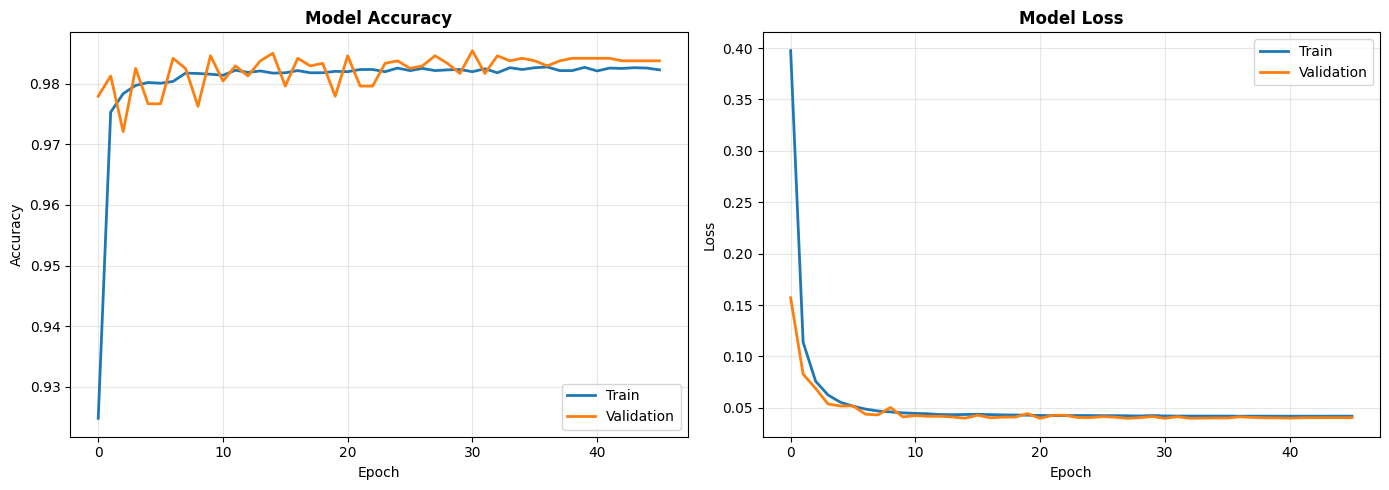

✅ Saved: training_history_v2.png


In [35]:
#============================================
# 7.BUILD & TRAIN MODEL
# ============================================
print("\n🏗️ BUILDING TinyML MODEL")
print("=" * 60)

# Lightweight model for ESP32
model = keras.Sequential([
    layers.Input(shape=(3,), name='sensor_input'),
    layers.Dense(16, activation='relu', name='hidden_1'),
    layers.Dense(8, activation='relu', name='hidden_2'),
    layers.Dense(1, activation='sigmoid', name='output')
], name='irrigation_model')

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

# Train
print("\n🚀 Training...")
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_v2.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: training_history_v2.png")


📊 MODEL EVALUATION

🎯 Test Accuracy: 98.69%

📋 Classification Report:
              precision    recall  f1-score   support

     OFF (0)       1.00      0.98      0.99      2643
      ON (1)       0.98      0.99      0.99      2156

    accuracy                           0.99      4799
   macro avg       0.99      0.99      0.99      4799
weighted avg       0.99      0.99      0.99      4799



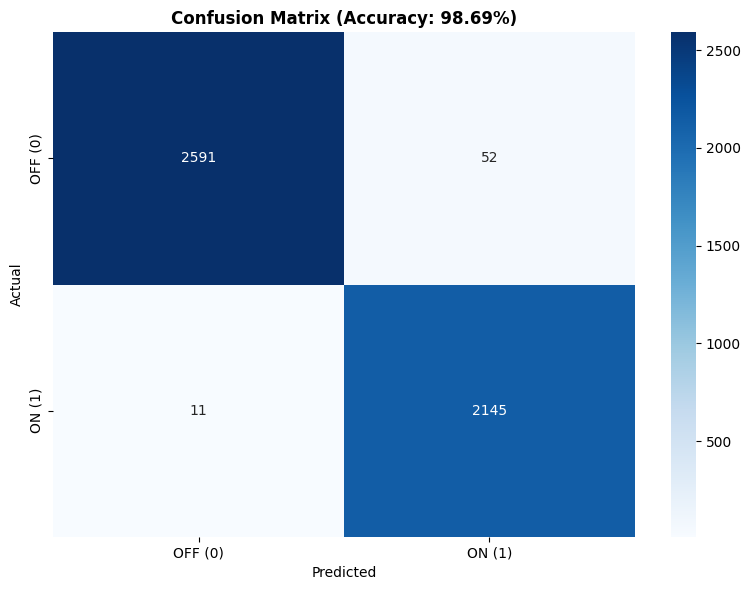

✅ Saved: confusion_matrix_v2.png


In [36]:
# ============================================
# 8.EVALUATE MODEL
# ============================================
print("\n📊 MODEL EVALUATION")
print("=" * 60)

# Predictions
y_pred_prob = model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Metrics
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Test Accuracy: {test_accuracy*100:.2f}%")

print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['OFF (0)', 'ON (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['OFF (0)', 'ON (1)'],
            yticklabels=['OFF (0)', 'ON (1)'])
plt.title(f'Confusion Matrix (Accuracy: {test_accuracy*100:.2f}%)', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix_v2.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: confusion_matrix_v2.png")


In [37]:
# ============================================
# 9.CONVERT TO TFLITE (INT8)
# ============================================
print("\n🔄 CONVERTING TO TensorFlow Lite (INT8)")
print("=" * 60)

def representative_dataset():
    for i in range(min(1000, len(X_train_scaled))):
        yield [X_train_scaled[i:i+1].astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

# Save
tflite_path = f"{CONFIG['model_name']}_int8.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# Size comparison
keras_size = sum(w.numpy().nbytes for w in model.weights) / 1024
tflite_size = len(tflite_model) / 1024

print(f"✅ TFLite Model Created")
print(f"\n📊 Model Sizes:")
print(f"   Keras (float32): {keras_size:.2f} KB")
print(f"   TFLite (int8):   {tflite_size:.2f} KB")
print(f"   Compression:     {keras_size/tflite_size:.1f}x")
print(f"\n💾 Saved: {tflite_path}")

# Get quantization parameters
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"\n🔢 Quantization Parameters:")
print(f"   Input Scale:      {input_details[0]['quantization'][0]}")
print(f"   Input Zero Point: {input_details[0]['quantization'][1]}")
print(f"   Output Scale:     {output_details[0]['quantization'][0]}")
print(f"   Output Zero Point:{output_details[0]['quantization'][1]}")



🔄 CONVERTING TO TensorFlow Lite (INT8)
Saved artifact at '/tmp/tmpgxvsbem4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='sensor_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137753429187792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753429195664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753429190096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753429182800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753429184336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137753429193936: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite Model Created

📊 Model Sizes:
   Keras (float32): 0.82 KB
   TFLite (int8):   3.27 KB
   Compression:     0.2x

💾 Saved: irrigation_model_v2_int8.tflite

🔢 Quantization Parameters:
   Input Scale:      0.003921568859368563
   Input Zero Point: -128
   Outpu

In [38]:
# ============================================
# 10.GENERATE ESP32 HEADER FILE
# ============================================
print("\n📝 GENERATING ESP32 HEADER FILE")
print("=" * 60)

# Get quantization params
input_scale = input_details[0]['quantization'][0]
input_zp = input_details[0]['quantization'][1]
output_scale = output_details[0]['quantization'][0]
output_zp = output_details[0]['quantization'][1]

# Convert to C array
c_array = ', '.join([f'0x{b:02x}' for b in tflite_model])

header_content = f'''/*
 * SoilMind - Irrigation TinyML Model v2
 * Auto-generated for ESP32
 *
 * Model: Binary Classification (Irrigation ON/OFF)
 * Input: 3 features (soil_moisture, temperature, humidity)
 * Output: 1 (probability of irrigation needed)
 * Quantization: INT8
 * Test Accuracy: {test_accuracy*100:.2f}%
 *
 * Agronomic Rules Used for Training:
 * - Soil moisture < 25% → Always irrigate
 * - Soil moisture < 40% AND temp > 28°C → Irrigate
 * - Soil moisture < 35% AND humidity < 45% → Irrigate
 * - Soil moisture >= 70% → Never irrigate
 */

#ifndef IRRIGATION_MODEL_H
#define IRRIGATION_MODEL_H

#include <stdint.h>

// ============================================
// MODEL DATA
// ============================================
#define IRRIGATION_MODEL_LEN {len(tflite_model)}

alignas(8) const unsigned char irrigation_model_data[] = {{
    {c_array}
}};

// ============================================
// NORMALIZATION PARAMETERS
// ============================================
// Formula: normalized = (value - min) / (max - min)

#define SOIL_MOISTURE_MIN {scaler.data_min_[0]:.2f}f
#define SOIL_MOISTURE_MAX {scaler.data_max_[0]:.2f}f
#define TEMPERATURE_MIN {scaler.data_min_[1]:.2f}f
#define TEMPERATURE_MAX {scaler.data_max_[1]:.2f}f
#define HUMIDITY_MIN {scaler.data_min_[2]:.2f}f
#define HUMIDITY_MAX {scaler.data_max_[2]:.2f}f

// ============================================
// QUANTIZATION PARAMETERS
// ============================================
#define INPUT_SCALE {input_scale}f
#define INPUT_ZERO_POINT {input_zp}
#define OUTPUT_SCALE {output_scale}f
#define OUTPUT_ZERO_POINT {output_zp}

// ============================================
// HELPER FUNCTIONS
// ============================================

// Normalize sensor value to 0-1 range
inline float normalize(float value, float min_val, float max_val) {{
    float norm = (value - min_val) / (max_val - min_val);
    if (norm < 0.0f) norm = 0.0f;
    if (norm > 1.0f) norm = 1.0f;
    return norm;
}}

// Normalize all inputs
inline void normalize_inputs(float soil_moisture, float temperature, float humidity, float* output) {{
    output[0] = normalize(soil_moisture, SOIL_MOISTURE_MIN, SOIL_MOISTURE_MAX);
    output[1] = normalize(temperature, TEMPERATURE_MIN, TEMPERATURE_MAX);
    output[2] = normalize(humidity, HUMIDITY_MIN, HUMIDITY_MAX);
}}

// Quantize float to int8
inline int8_t quantize(float value) {{
    int32_t result = (int32_t)roundf(value / INPUT_SCALE) + INPUT_ZERO_POINT;
    if (result < -128) result = -128;
    if (result > 127) result = 127;
    return (int8_t)result;
}}

// Dequantize int8 to float probability
inline float dequantize(int8_t value) {{
    return ((float)value - OUTPUT_ZERO_POINT) * OUTPUT_SCALE;
}}

// Get irrigation decision
#define IRRIGATION_THRESHOLD 0.5f

inline int should_irrigate(float probability) {{
    return probability >= IRRIGATION_THRESHOLD ? 1 : 0;
}}

#endif // IRRIGATION_MODEL_H
'''

header_path = f"{CONFIG['model_name']}.h"
with open(header_path, 'w') as f:
    f.write(header_content)

print(f"✅ Header File Generated: {header_path}")
print(f"   Size: {len(header_content)/1024:.2f} KB")


📝 GENERATING ESP32 HEADER FILE
✅ Header File Generated: irrigation_model_v2.h
   Size: 22.31 KB


In [39]:

# ============================================
# 11.SAVE NEW DATASET
# ============================================
print("\n💾 SAVING NEW DATASET")
print("=" * 60)

# Save dataset with new labels
df_new = df[['soil_moisture', 'temperature', 'humidity', 'irrigation_new']].copy()
df_new = df_new.rename(columns={'irrigation_new': 'irrigation'})
df_new.to_csv('irrigation_dataset_v2.csv', index=False)

print(f"✅ Saved: irrigation_dataset_v2.csv")
print(f"   Samples: {len(df_new):,}")
print(f"   ON:  {(df_new['irrigation']==1).sum():,} ({(df_new['irrigation']==1).mean()*100:.1f}%)")
print(f"   OFF: {(df_new['irrigation']==0).sum():,} ({(df_new['irrigation']==0).mean()*100:.1f}%)")


💾 SAVING NEW DATASET
✅ Saved: irrigation_dataset_v2.csv
   Samples: 23,995
   ON:  10,780 (44.9%)
   OFF: 13,215 (55.1%)


In [40]:
# ============================================
# 12.FINAL SUMMARY
# ============================================
print("\n" + "=" * 60)
print("🎉 FINAL SUMMARY - SoilMind Irrigation Model v2")
print("=" * 60)

print(f'''
📊 MODEL PERFORMANCE
{'─' * 40}
   Test Accuracy:    {test_accuracy*100:.2f}%
   Precision (ON):   {cm[1,1]/(cm[0,1]+cm[1,1])*100:.2f}%
   Recall (ON):      {cm[1,1]/(cm[1,0]+cm[1,1])*100:.2f}%

📦 MODEL SPECIFICATIONS
{'─' * 40}
   Architecture:     3 → 16 → 8 → 1
   Parameters:       {model.count_params()}
   Size (TFLite):    {tflite_size:.2f} KB
   Quantization:     INT8

🌱 AGRONOMIC RULES
{'─' * 40}
   • Critical:   soil_moisture < 25% → IRRIGATE
   • Hot+Dry:    soil_moisture < 40% & temp > 28°C → IRRIGATE
   • Dry Air:    soil_moisture < 35% & humidity < 45% → IRRIGATE
   • Wet Soil:   soil_moisture >= 70% → NO IRRIGATION

📁 GENERATED FILES
{'─' * 40}
   ├── {tflite_path}
   ├── {header_path}
   ├── irrigation_dataset_v2.csv
   ├── training_history_v2.png
   ├── confusion_matrix_v2.png
   └── new_labels_visualization.png

✅ Model ready for ESP32 deployment!
''')


🎉 FINAL SUMMARY - SoilMind Irrigation Model v2

📊 MODEL PERFORMANCE
────────────────────────────────────────
   Test Accuracy:    98.69%
   Precision (ON):   97.63%
   Recall (ON):      99.49%

📦 MODEL SPECIFICATIONS
────────────────────────────────────────
   Architecture:     3 → 16 → 8 → 1
   Parameters:       209
   Size (TFLite):    3.27 KB
   Quantization:     INT8

🌱 AGRONOMIC RULES
────────────────────────────────────────
   • Critical:   soil_moisture < 25% → IRRIGATE
   • Hot+Dry:    soil_moisture < 40% & temp > 28°C → IRRIGATE  
   • Dry Air:    soil_moisture < 35% & humidity < 45% → IRRIGATE
   • Wet Soil:   soil_moisture >= 70% → NO IRRIGATION

📁 GENERATED FILES
────────────────────────────────────────
   ├── irrigation_model_v2_int8.tflite
   ├── irrigation_model_v2.h
   ├── irrigation_dataset_v2.csv
   ├── training_history_v2.png
   ├── confusion_matrix_v2.png
   └── new_labels_visualization.png

✅ Model ready for ESP32 deployment!

